<a href="https://colab.research.google.com/github/hiro201025/othello_AI/blob/main/Check_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks/Othello_AI'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [166]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
import copy
from torch.utils.data import Dataset, DataLoader
import torch

from torch.nn import Conv2d, Linear, ReLU, Dropout
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

from torch.optim import Adam
from sklearn.metrics import accuracy_score

# Datset

In [167]:
#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data.sample(100)
#data = data[data[64]!=0]
#data = data.drop_duplicates()
#data
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する

In [168]:
#DEBUG = True

#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する
#data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
#cols = [ i for i in range(64)]
#data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
#data = data.drop_duplicates()
#data.to_csv('drop_dups.csv', index=False)
#
#if DEBUG:
#    data = data.sample(n=10000)

data = pd.read_csv(os.path.join(ROOT_PATH,'sample_kifu.csv'))
data.columns = data.columns.astype(np.int)


data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
cols = [ i for i in range(64)]
data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
gc.collect()

print(data.shape)
print(data.columns)
data.head()

(100, 68)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
            67],
           dtype='int64')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
0,0,0,0,0,0,-1,0,0,0,0,-1,1,-1,-1,0,0,0,1,1,1,-1,1,0,0,0,0,-1,-1,-1,1,0,0,0,0,-1,-1,-1,1,0,0,0,0,-1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,B,42
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,B,60
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1,1,1,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,W,57
3,0,0,-1,-1,-1,0,0,0,0,0,-1,-1,-1,-1,0,-1,0,-1,-1,1,-1,-1,-1,-1,0,1,-1,1,-1,-1,-1,-1,1,1,1,-1,1,-1,1,-1,0,1,1,1,-1,-1,-1,-1,0,0,1,1,1,-1,0,-1,0,0,0,1,0,-1,0,0,7,2,B,20
4,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,-1,-1,1,-1,1,0,1,1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,0,-1,1,-1,-1,1,-1,0,-1,-1,-1,-1,1,1,0,0,1,1,1,1,1,1,0,0,8,6,B,8


In [169]:
print(data.iloc[1, :64].values.reshape(8, 8))
print(data.iloc[2, :64].values.reshape(8, 8))

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 -1 1 0 0 0]
 [0 0 0 1 -1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 -1 0 0 0 0]
 [0 0 0 -1 1 1 0 0]
 [0 0 0 -1 -1 0 0 0]
 [0 0 0 0 -1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [170]:
class OCDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.States = df.iloc[:, :64] #盤面
        self.player = df.iloc[:, 66] #W or B
        self.action = 8*(df.iloc[:, 65]-1) + (df.iloc[:, 64]-1) #0-63のどこに置くか

    def __len__(self):
        return self.States.shape[0]

    def __getitem__(self, idx):
        state_can = np.zeros((8,8))
        state = self.States.iloc[idx].values.reshape(8,8)

        state_my = (state == 1).astype(np.uint8) #自分の石の位置
        state_op = (state == -1).astype(np.uint8) #相手の石の位置
        state_on = (state != 0).astype(np.uint8)   # 盤面の石の位置
        states = np.stack( [state_on, state_op, state_my] )

        states = torch.tensor( states, dtype=torch.float32 )
        action = torch.tensor( self.action.iloc[idx], dtype=torch.int64 )

        return states, action, self.player.iloc[idx]

# ここから先はコピーして、Datasetだけ変えて実行してください

In [171]:
sample_dataset = OCDataset(data)

sample_loader = DataLoader(
        dataset = sample_dataset,
        batch_size=100,
        shuffle=False
        )

States, Actions, players = iter(sample_loader).next()

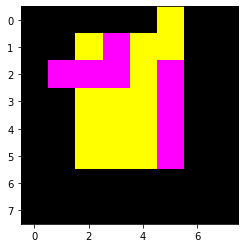

Player : B
Answer : 2



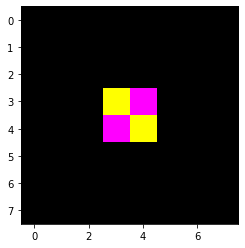

Player : B
Answer : 19



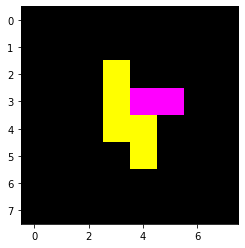

Player : W
Answer : 42



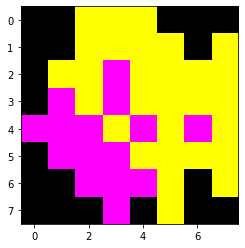

Player : B
Answer : 14



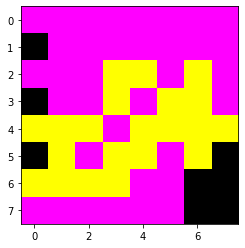

Player : B
Answer : 47



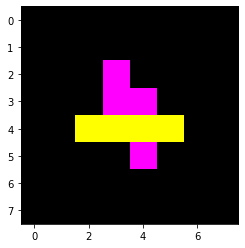

Player : B
Answer : 45



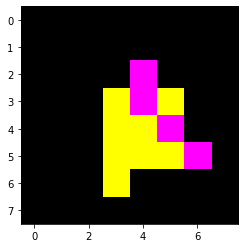

Player : B
Answer : 38



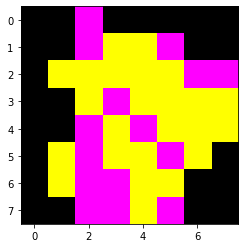

Player : W
Answer : 3



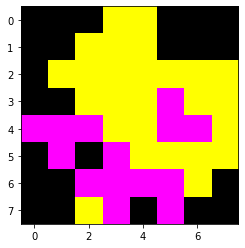

Player : B
Answer : 25



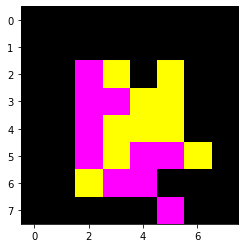

Player : B
Answer : 58

tensor([[[0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 

In [172]:
for i in range(10):
    plt.imshow( States[i].detach().numpy().transpose(1,2,0) )
    plt.show()
    print(f"Player : {players[i]}")
    print("Answer :", Actions[i].detach().numpy())
    print("="*30, "\n")

print(States[0])
print(States[2])

In [173]:
train_df = data
state_name = [f'state{x}' for x in range(64)]
train_df.columns = state_name + ["action_x", "action_y", "player", "count_void"]
train_df.insert(66, "player_w", 0)
train_df.insert(67, "player_b", 0)
train_df["player_w"].where(train_df["player"] != 'W', 1, inplace = True)
train_df["player_b"].where(train_df["player"] != 'B', 1, inplace = True)
train_df = train_df.drop("player", axis = 1)
train_df["action_x"] = train_df["action_x"].apply(lambda x: x-1)
train_df["action_y"] = train_df["action_y"].apply(lambda x: x-1)
train_df.insert(66, "action", 0)
train_df["action"] = train_df["action_x"] + 8 * train_df["action_y"]
train_df = train_df.astype("int8")
#train_df.info()
#print(train_df.describe)
train_df.head()

,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,state10,state11,state12,state13,state14,state15,state16,state17,state18,state19,state20,state21,state22,state23,state24,state25,state26,state27,state28,state29,state30,state31,state32,state33,state34,state35,state36,state37,state38,state39,state40,state41,state42,state43,state44,state45,state46,state47,state48,state49,state50,state51,state52,state53,state54,state55,state56,state57,state58,state59,state60,state61,state62,state63,action_x,action_y,action,player_w,player_b,count_void
0,0,0,0,0,0,-1,0,0,0,0,-1,1,-1,-1,0,0,0,1,1,1,-1,1,0,0,0,0,-1,-1,-1,1,0,0,0,0,-1,-1,-1,1,0,0,0,0,-1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,1,42
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,19,0,1,60
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1,1,1,0,0,0,0,0,-1,-1,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,42,1,0,57
3,0,0,-1,-1,-1,0,0,0,0,0,-1,-1,-1,-1,0,-1,0,-1,-1,1,-1,-1,-1,-1,0,1,-1,1,-1,-1,-1,-1,1,1,1,-1,1,-1,1,-1,0,1,1,1,-1,-1,-1,-1,0,0,1,1,1,-1,0,-1,0,0,0,1,0,-1,0,0,6,1,14,0,1,20
4,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,-1,-1,1,-1,1,0,1,1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,0,-1,1,-1,-1,1,-1,0,-1,-1,-1,-1,1,1,0,0,1,1,1,1,1,1,0,0,7,5,47,0,1,8


In [174]:
print(train_df.iloc[1, :64].values.reshape(8, 8))
print(train_df.iloc[2, :64].values.reshape(8, 8))

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0]
 [ 0  0  0  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0 -1  1  1  0  0]
 [ 0  0  0 -1 -1  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


In [175]:
class TDatasets(Dataset):
  def __init__(self, state_df, action, player_df, mode = None):
    self.state_np = state_df.values
    self.action = action.values
    self.player_w = player_df["player_w"].values
    self.player_w = np.where(self.player_w == 1, 1, -1) 
    self.player_b = player_df["player_b"].values
    self.player_b = np.where(self.player_b == 1, 1, -1)
    self.mode = mode

  def __len__(self):
    return self.player_w.shape[0]
  
  def __getitem__(self, idx):
    state = self.state_np[idx].reshape((-1, 8, 8)).astype("float32")
    white_st = np.where(state == self.player_w[idx], 1, 0)
    black_st = np.where(state == self.player_b[idx], 1, 0)
    bw_st = np.where(state != 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 1).reshape(3, 8, 8) #check INPUT_SIZE
    action = self.action[idx]
    if self.mode:
      state, action = transform(state, action, self.mode)
    state = torch.tensor(state).float()
    action = torch.tensor(action).long()
    return state, action, self.player_b[idx]

In [176]:
state_df = train_df[state_name]
action_df = train_df["action"]
player_df = train_df[["player_w", "player_b"]]

In [177]:
sample_dataset = TDatasets(state_df, action_df, player_df)

sample_loader = DataLoader(
        dataset = sample_dataset,
        batch_size=100,
        shuffle=False
        )

States, Actions, players = iter(sample_loader).next()

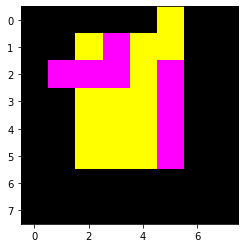

Player : 1
Answer : 2



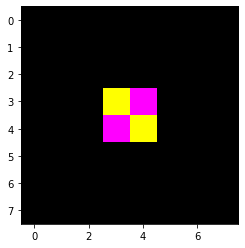

Player : 1
Answer : 19



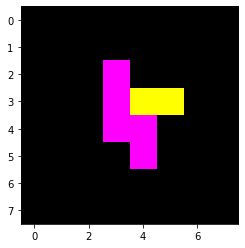

Player : -1
Answer : 42



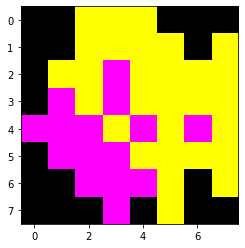

Player : 1
Answer : 14



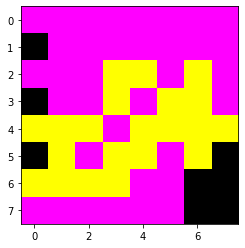

Player : 1
Answer : 47



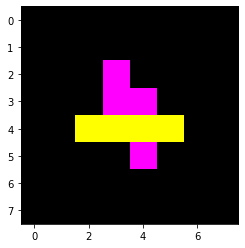

Player : 1
Answer : 45



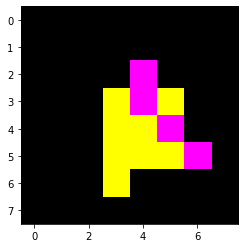

Player : 1
Answer : 38



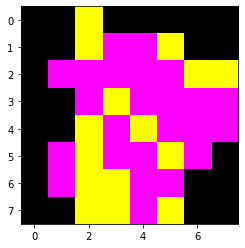

Player : -1
Answer : 3



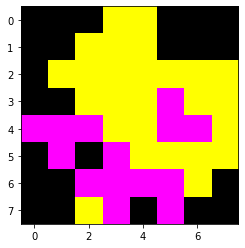

Player : 1
Answer : 25



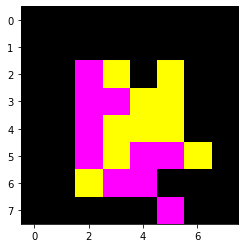

Player : 1
Answer : 58

tensor([[[0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 

In [178]:
for i in range(10):
    plt.imshow( States[i].detach().numpy().transpose(1,2,0) )
    plt.show()
    print(f"Player : {players[i]}")
    print("Answer :", Actions[i].detach().numpy())
    print("="*30, "\n")

print(States[0])
print(States[2])